<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 22

# Student 1: Ruichen Hu(1674544)

# Student 2: Simin Sun(1692933)

# Student 3: Siyue Chen(1657402)

# Downloading Data and Preliminaries

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [ ]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [ ]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [ ]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [ ]:
def plot_example(x, x_gt=None, x_pred=None, x_base = None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5, label = 'given continuous')
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--', label = 'my_pred')
    if x_base is not None:
        plt.plot(x_base[:, 0], x_base[:, 1], color='purple', linestyle='--', label = 'baseline_pred')
    if fn is None:
        plt.legend()
        plt.show()
    else:
        plt.savefig(fn)

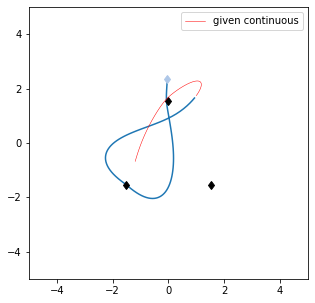

Charges are [-0.64527653 -0.21612742 -0.96768868]


In [ ]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [ ]:
## change the input format, using customize length of timestamps as inputs, serving as a sliding window
def generate_dataset(simulation,charges,window_size):
    trains,labels=[],[]
    for i in range(len(simulation)):        
        train=[]
        lable=[]
        for j in range(90-window_size): ## only 90 timestamps' positions kept
            train.append([item for sublists in simulation[i][j:j+window_size] for item in sublists])
            lable.append(charges[i])
        trains.append(train)
        labels.append(lable)
    return torch.tensor(trains,dtype=torch.float),torch.tensor(labels,dtype=torch.float)

In [ ]:
## customize length: 
window_size=40

## reformat the train, valid and test datasets
train_positions,train_charges=generate_dataset(simulation_train,charges_train,window_size)
valid_positions,valid_charges=generate_dataset(simulation_valid,charges_valid,window_size)
test_positions,test_charges=generate_dataset(simulation_test,charges_test,window_size)

print(train_positions.size(),train_charges.size())

torch.Size([800, 50, 80]) torch.Size([800, 50, 3])


In [ ]:

train_dataset = TensorDataset(train_positions, train_charges)
val_dataset = TensorDataset(valid_positions, valid_charges)
test_dataset = TensorDataset(test_positions, test_charges)
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## Model Implementation

In [ ]:
class ChargePredictor(nn.Module):
    
    def __init__(self,
                 input_dim=window_size * 2, 
                 hidden_dim=32, 
                 hidden_dense_dim = 32,
                 charge_nums=3,
                 dense_dropout = 0.4,
                 num_layers=1
                 ):
        '''
        input_dim: window_size * 2 = input size of LSTM
        hidden_dim: size of LSTM hidden layer
        num_layers: number of hidden layers in each LSTM
        hidden_dense_dim: size of the dense layer after LSTM
        dense_dropout: rate for dropout layer after the dense layer
        '''
        
        super(ChargePredictor, self).__init__()
        
        # Process data with LSTM
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)  # batch_size, hidden_dim
        
        # Fully connected layer after RNN output, to learn more complex relations
        self.f0 = nn.Linear(hidden_dim, hidden_dense_dim)

        self.activation = nn.ReLU()   ##nn.Sigmoid() loss 0.01  relu  0.009

        # Dropout to regularize this dense layer
        self.drop = nn.Dropout(p=dense_dropout)

        self.f1 = nn.Linear(hidden_dim, charge_nums)

        ## use MSE to caculate the loss
        self.criterion = nn.MSELoss()
     
        self.optimizer = torch.optim.Adam(self.parameters()) 
    
    def forward(self, positions):
        """
        Forward pass of trainable model. It predicts charges
        in the descriptive sentence as if the previous prediction was correct
        by substitution of the ground truth charges for the previous timestamps.

        Input:
        posiitons: (batch_size, num_positions)*window_size

        Outputs:
        output: num_predictions * (pred_c2, pred_c3, pred_c4,)
        """

        concat_embeddings = torch.cat([positions], dim=1) 
        rnn_output, _ = self.rnn(concat_embeddings) 
        # output = self.f1(rnn_output) 

        # To further process, put the data through a dense layer
        output = self.f0(rnn_output)

        # apply activation
        output = self.activation(output)

        # and apply dropout!
        output = self.drop(output)

        # Map rnn output to vector of length num_words
        output = self.f1(output) #(batch_size, num_time + 1, 10), 10 -> 5 positions(x, y)
        return output
        

## Model Training

In [ ]:
import time

def train(model,device,dataloader):
    model.train()
    total_correct, total_count = 0, 0

    for positions,charges in dataloader:
        target_charges = charges.to(device)
        
        model.optimizer.zero_grad()

        pred_charges = model(positions)

        # loss=loss1+loss2+...+loss_n
        loss = model.criterion(pred_charges, target_charges)
        loss.backward()
        
        # set a gradient threshold to avoid exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()

    return loss.item()

In [ ]:
def evaluate(model,device,dataloader):
    model.eval()
    total_correct, total_count = 0, 0

    with torch.no_grad():
        for positions,charges in dataloader:
            
            charges = charges.to(device)
            positions = positions.to(device)

            y_pred = model(positions)
            y_true = charges

            loss = model.criterion(y_pred, y_true)

    return loss.item()

In [ ]:
EPOCHS = 40

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

model = ChargePredictor(
                 hidden_dim=32,
                 hidden_dense_dim = 32,
                 charge_nums=3,
                 num_layers=1).to(device) 

train_loss, cali_train_loss, val_loss, test_loss = [], [], [], []
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss.append(train(model,device,train_dataloader))
    val_loss.append(evaluate(model,device,val_dataloader))
    test_loss.append(evaluate(model,device,test_dataloader))
    
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss: {:5.3f}    '
          'validation loss: {:5.3f}'.format(epoch,
                                     time.time() - epoch_start_time, 
                                     train_loss[-1],
                                    #  cali_train_loss[-1],
                                     val_loss[-1],
                                     test_loss[-1]))
    print('-' * 80)

--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.35s | train loss: 0.155    validation loss: 0.148
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   2 | time:  0.35s | train loss: 0.093    validation loss: 0.084
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   3 | time:  0.35s | train loss: 0.090    validation loss: 0.067
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   4 | time:  0.35s | train loss: 0.078    validation loss: 0.068
--------------------------------------------------------------------------------
--------------------------------

## Evaluation

Train loss: 0.016389641910791397
Validation loss: 0.008314969949424267
Test loss: 0.008172334171831608


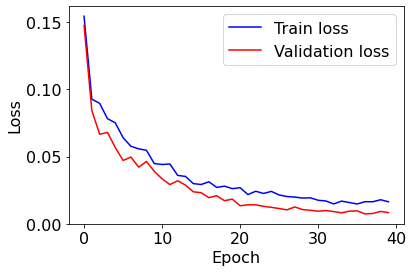

In [ ]:
def PlotLoss():
  f, ax = plt.subplots(1,1, figsize=(6,4))

  fnt=16
  ax.plot(train_loss, color='blue', label='Train loss')
  ax.plot(val_loss, color='red', label='Validation loss')

  ax.legend(fontsize=fnt)
  ax.tick_params(axis='both', labelsize=fnt)

  ax.set_xlabel("Epoch", fontsize=fnt)
  ax.set_ylabel("Loss", fontsize=fnt);

PlotLoss()
test_loss = evaluate(model,device,test_dataloader)
print(f"Train loss: {train_loss[-1]}\nValidation loss: {val_loss[-1]}\nTest loss: {test_loss}")

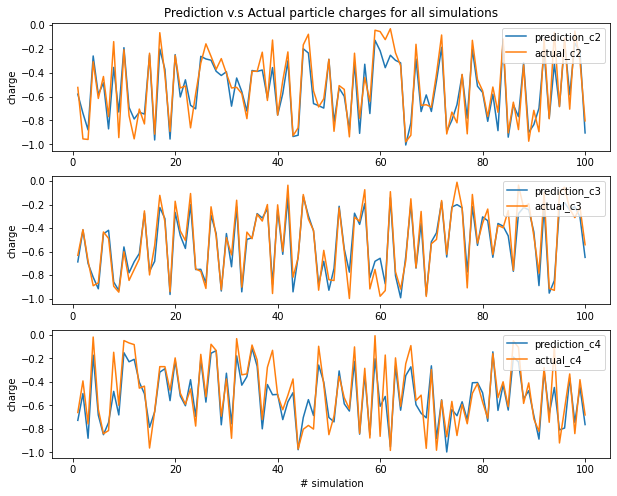

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction():
  c_test = test_charges.numpy()
  prediction = model(test_positions)
  prediction = prediction.detach().numpy()
  x = np.arange(1, 101)
  p_2 = []
  p_3 = []
  p_4 = []
  true_2 = []
  true_3 = []
  true_4 = []
  for p in prediction:
    p_2.append(p[-1][0])
    p_3.append(p[-1][1])
    p_4.append(p[-1][2])
  for i in range(len(c_test)):
    true_2.append(c_test[i][0][0])
    true_3.append(c_test[i][0][1])
    true_4.append(c_test[i][0][2])

  fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,8))

  # plot lines
  ax1.plot(x, p_2, label = "prediction_c2")
  ax1.plot(x, true_2, label = "actual_c2")
  ax1.legend(loc="upper right")
  ax2.plot(x, p_3, label = "prediction_c3")
  ax2.plot(x, true_3, label = "actual_c3")
  ax2.legend(loc="upper right") 
  ax3.plot(x, p_4, label = "prediction_c4")
  ax3.plot(x, true_4, label = "actual_c4")
  ax3.legend(loc="upper right")
  ax3.set_xlabel('# simulation')
  ax1.set_ylabel('charge')
  ax2.set_ylabel('charge')
  ax3.set_ylabel('charge')
  ax1.set_title("Prediction v.s Actual particle charges for all simulations")
  plt.show()
  
plot_prediction()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


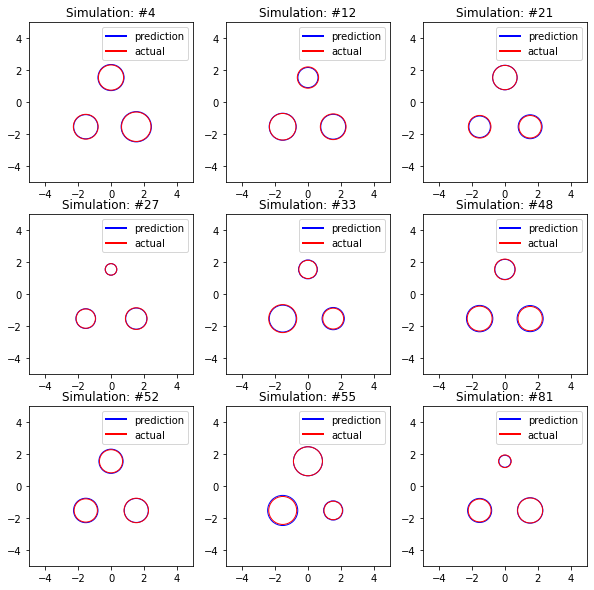

In [ ]:
from matplotlib.lines import Line2D
def plot_prediction(choices):
  c_test = test_charges
  prediction = model(test_positions)
  prediction = prediction.detach().numpy()
  pred = []
  actual = []
  axis_x = [-1.53846154,1.53846154, 0 ]
  axis_y = [-1.53846154, -1.53846154, 1.53846154 ]
  
  for x in choices:
    pred.append(prediction[x][-1])
    actual.append(c_test[x][0])
  
  fig, ax = plt.subplots(3, 3, figsize=(10,10))

  for i in range(9):

    ax[i//3][i%3].scatter(axis_x, axis_y, s = -pred[i]*1000, c = "", edgecolors = "blue", label = 'prediction')
    ax[i//3][i%3].scatter(axis_x, axis_y, s = -actual[i]*1000, c = "", edgecolors = "red", label = 'actual')
    ax[i//3][i%3].set_xlim([-5, 5])
    ax[i//3][i%3].set_ylim([-5, 5])
    ax[i//3][i%3].set_title("Simulation: #" + str(choices[i]))

    custom_lines = [Line2D([0], [0], color='blue', lw=2),
                    Line2D([0], [0], color='red', lw=2)]
    ax[i//3][i%3].legend(custom_lines, ['prediction', 'actual'])  
  plt.show()

# choices = np.random.randint(100, size=9)
good = [4, 12, 21, 27, 33, 48, 52, 55, 81] ## 0, 1, 27,
plot_prediction(good)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


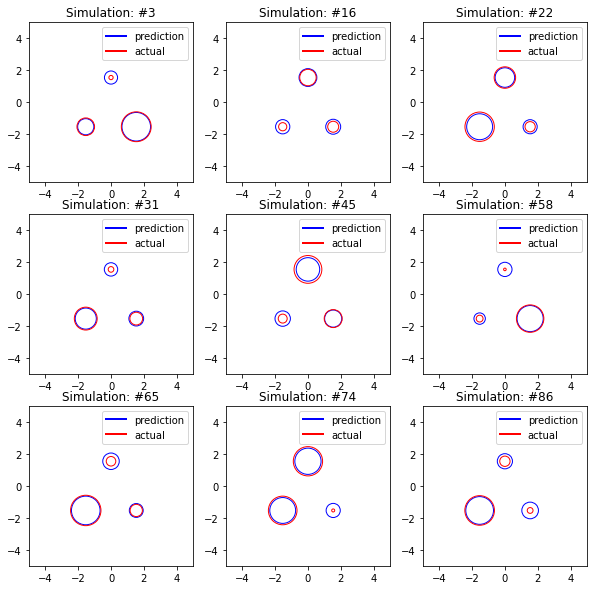

In [ ]:
bad = [3, 16, 22, 31, 45, 58, 65, 74, 86] # 38, 45,
plot_prediction(bad)

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
def generate_dataset_3_2(simulation,input_charges,window_size):
    positions,output_charges,labels=[],[],[]
    for i in range(len(simulation)):  
       train,label,charge=[],[],[]
       for j in range(len(simulation[i])-110,len(simulation[i])-window_size,1):    
          train.append([item for sublists in simulation[i][j:j+window_size] for item in sublists])
          label.append(simulation[i][j+window_size]) 
          charge.append(input_charges[i])
       positions.append(train)
       output_charges.append(charge)
       labels.append(label)
    return torch.tensor(positions,dtype=torch.float),torch.tensor(output_charges,dtype=torch.float),torch.tensor(labels,dtype=torch.float)

In [ ]:
def concat_data(trainX, train_continue):
  new_data = []
  min_v = 200
  for i in range(len(trainX)): 
    new_data.append(np.concatenate((trainX[i], train_continue[i]), axis=0))
  return new_data

In [ ]:
window_size=30
new_train = concat_data(simulation_train_task32, simulation_continued_train)
new_valid = concat_data(simulation_valid, simulation_continued_valid)
train_positions,train_charges,train_labels=generate_dataset_3_2(new_train,charges_train,window_size) 
valid_positions,valid_charges,valid_labels=generate_dataset_3_2(new_valid,charges_valid,window_size) 
print(train_positions.size())
print(train_charges.shape)

torch.Size([150, 80, 60])
torch.Size([150, 80, 3])


In [ ]:
train_dataset = TensorDataset(train_charges,train_positions, train_labels)
val_dataset = TensorDataset(valid_charges,valid_positions, valid_labels)
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=True)

## Model Implementation

In [ ]:
class PreprocessMLP(nn.Module):
    """
    Preprocess charge, position input and map them to an embedding by a MLP.
    The embedding is the output of MLP and input of LSTM.
    """

    def __init__(self, in_dim, mlp_hidden_dim=16, out_dim=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.mlp(x)

class ContinuousPositionPredictor(nn.Module):
    
    def __init__(self,
                 num_positions=window_size*2,
                 output_size=2,
                 num_particles=3,
                 mpl_hidden_dim=16,
                 embed_dim=16, 
                 hidden_dim=16, 
                 num_layers=1,
                 hidden_dense_dim=16,
                 dense_dropout=0):

        '''
        mpl_hidden_dim: hidden layer dim in MLP
        embed_dim: embedding size of charge, position = output size of MLP block = input size of LSTM
        hidden_dim: size of LSTM hidden layer
        num_layers: number of hidden layers in each LSTM
        hidden_dense_dim: size of the dense layer after LSTM
        dense_dropout: rate for dropout layer after the dense layer
        '''
        
        super(ContinuousPositionPredictor, self).__init__()

        self.embed_dim = embed_dim
        self.num_positions = num_positions
        self.num_particles = num_particles

        self.chargeMLP = PreprocessMLP(num_particles, mpl_hidden_dim, self.embed_dim)
        self.positionMLP = PreprocessMLP(num_positions, mpl_hidden_dim, self.embed_dim)
        
        self.rnn = nn.LSTM(embed_dim*2, hidden_dim, num_layers=num_layers, batch_first=True) 

        self.f0 = nn.Linear(hidden_dim, hidden_dense_dim)
        self.relu = nn.ReLU()

        # Actually dropout it is not used due to performance degradation
        self.drop = nn.Dropout(p=dense_dropout)

        # Map to number of positions needed to be predicted
        self.f1 = nn.Linear(hidden_dense_dim, output_size)
        
        # No need of an additional activation layer, because it is a regression task
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())  # weight_decay insreases loss dramatically,
    
    def forward(self, charges, positions):
        """
        Forward pass of trainable model. It predicts each next word
        in the descriptive sentence as if the previous word was correct
        by substitution of the ground truth word for the previous word.

        Input:
        charges: batch_size*(1, 1, num_particles) num_particles = 3
        posiitons: batch_size*(1, #window, num_positions) num_positions = window_size*2

        Outputs:
        output: (batch_size, #window, 2)
        """

        charge_vector = self.chargeMLP(charges.type(torch.FloatTensor))
        # charge_vector = charge_vector.unsqueeze(1)
        position_embedding = self.positionMLP(positions)

        # Concatenate all our inputs -> charge and position
        concat_embeddings = torch.cat([charge_vector, position_embedding], dim=2)

        # Feed packed input sequence to rnn
        rnn_output, _ = self.rnn(concat_embeddings)

        output = self.f0(rnn_output)

        output = self.relu(output)

        # Dropout is not used in the final model
        output = self.drop(output)

        output = self.f1(output) 
        return output

## Model Training

In [ ]:
import time

def train(dataloader, model):
    model.train()
    num_data = 0
    total_loss = 0

    for charges, positions,labels in dataloader:
        charges = charges.to(device)
        positions = positions.to(device)
    
        model.optimizer.zero_grad()
        y_pred = model(charges, positions)
        
        y_true = labels

        loss = model.criterion(y_pred, y_true)

        num_data += positions.shape[0]
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()

    return total_loss/num_data

In [ ]:
def evaluate(dataloader, model):
    model.eval()
    num_data = 0
    total_loss = 0

    with torch.no_grad():
        for charges, positions,labels in dataloader:
            
            charges = charges.to(device)
            positions = positions.to(device)
            y_pred = model(charges, positions)
            y_true = labels
            loss = model.criterion(y_pred, y_true)

            num_data += positions.shape[0]
            total_loss += loss.item()

    return total_loss/num_data

In [ ]:
from tqdm import tqdm

EPOCHS = 60

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
model = ContinuousPositionPredictor(
                 mpl_hidden_dim=32,
                 embed_dim=32, 
                 hidden_dim=32, # output size of MLP, input size of LSTM, embedding size of charge, position
                 num_layers=1,
                 hidden_dense_dim=32,
                 ### dropout increases training loss dramatically such that validation loss and test loss are lower than training loss! Thus, dropout is removed.
                 dense_dropout=0).to(device)  


train_loss, val_loss = [], []
for epoch in tqdm(range(1, EPOCHS + 1)):
    epoch_start_time = time.time()
    train_loss.append(train(train_dataloader, model))
    val_loss.append(evaluate(val_dataloader, model))

100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


## Evaluation

In [ ]:
def get_feed_in_data(input_positions, charge, step):
    sliced_positions=[]
    input_len=len(input_positions)
    new_charges = []
    for j in range(40,input_len-step+1,1):      
      sliced_positions.append([item for sublists in input_positions[j:j+step] for item in sublists])
      new_charges.append(charge)
    return torch.tensor(sliced_positions,dtype=torch.float), torch.tensor(new_charges,dtype=torch.float)

In [ ]:
def recursive_predict(positions,charges,window_size, index):
    predicted_continus=[]
    for i in range(len(simulation_continued_test[index])):
        new_position, new_chages =get_feed_in_data(positions,charges, window_size)
        predict=model(new_chages.unsqueeze(0),new_position.unsqueeze(0))
        positions=torch.cat([positions[1:], predict[0][-1].unsqueeze(0)])
        predicted_continus.append(predict[0][-1].tolist())
    predicted_continus=np.array(predicted_continus)
    return predicted_continus

In [ ]:
def evaluate_test(charge, test, test_label, model, window_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i in range(len(test)):
            y_pred=recursive_predict(torch.tensor(test[i],dtype=torch.float),charge[i], window_size, i)
            y_true = test_label[i]
            loss = model.criterion(torch.tensor(y_pred), torch.tensor(y_true))
            total_loss += loss.item()
    return total_loss/len(test)


In [ ]:
from scipy import interpolate
def base_loss():
  total_loss = 0
  for i in range(len(simulation_test)): 
    test_data = simulation_test[i] 
    y_true = simulation_continued_test[i]
    y_pred = []
    for j in range(len(simulation_continued_test[i])):
      x1,y1 = test_data[-2]
      x2,y2 = test_data[-1]
      x = [x1,x2]
      y = [y1,y2]
      f = interpolate.interp1d(x, y, fill_value='extrapolate')
      x3= x2 + (x2-x1)
      y_pred.append([x3,float(f(x3))])
      test_data = np.append(test_data,[[x3,float(f(x3))]], axis=0)
      test_data = test_data[1:] 
     
    loss = model.criterion(torch.tensor(y_pred), torch.tensor(y_true))
    total_loss += loss
  return total_loss/len(charges_test)

Train loss: 0.0002747625360886256
Validation loss: 0.0008573965542018414
Test loss:0.3285925749863506
Baseline loss:2.884847350343732


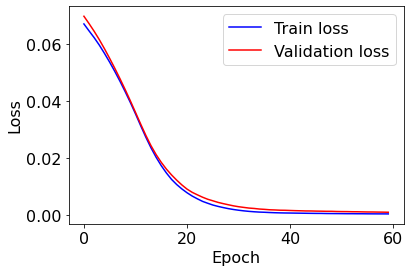

In [ ]:
def PlotLoss():
  f, ax = plt.subplots(1,1, figsize=(6,4))

  fnt=16
  ax.plot(train_loss, color='blue', label='Train loss')
  ax.plot(val_loss, color='red', label='Validation loss')

  ax.legend(fontsize=fnt)
  ax.tick_params(axis='both', labelsize=fnt)

  ax.set_xlabel("Epoch", fontsize=fnt)
  ax.set_ylabel("Loss", fontsize=fnt);

PlotLoss()
test_loss = evaluate_test(charges_test, simulation_test, simulation_continued_test, model, window_size)
print(f"Train loss: {train_loss[-1]}\nValidation loss: {val_loss[-1]}\nTest loss:{test_loss}\nBaseline loss:{base_loss()}")

In [ ]:
def base_predict(positions,charges,window_size, index):
    y_pred = []
    for j in range(len(simulation_continued_test[i])):
      x1,y1 = positions[-2]
      x2,y2 = positions[-1]
      x = [x1,x2]
      y = [y1,y2]
      f = interpolate.interp1d(x, y, fill_value='extrapolate')
      x3= x2 + (x2-x1)
      y_pred.append([x3,float(f(x3))])
      positions = np.append(positions,[[x3,float(f(x3))]], axis=0)
      positions = positions[1:] 
    return y_pred


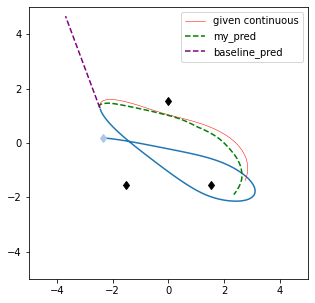

Simuation#0
Charges [-0.99508806 -0.44820919 -0.2730329 ]


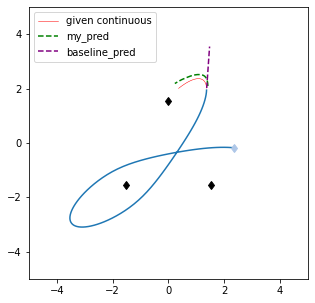

Simuation#1
Charges [-0.98451836 -0.1667747  -0.34789858]


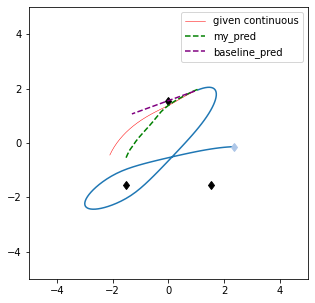

Simuation#2
Charges [-0.0918499  -0.35406486 -0.68168262]


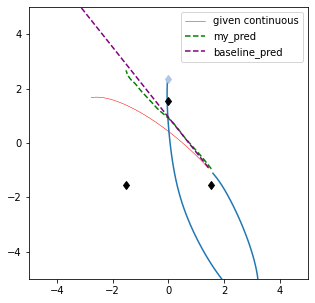

Simuation#3
Charges [-0.81015605 -0.67512385 -0.16594701]


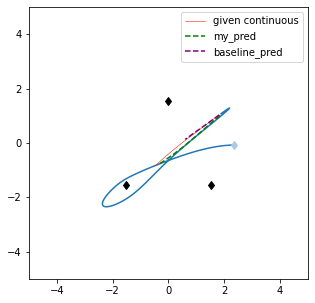

Simuation#4
Charges [-0.71567692 -0.8646266  -0.92353406]


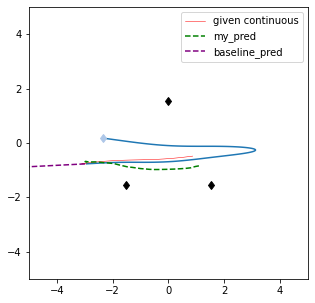

Simuation#5
Charges [-0.1375296  -0.05280612 -0.95305736]


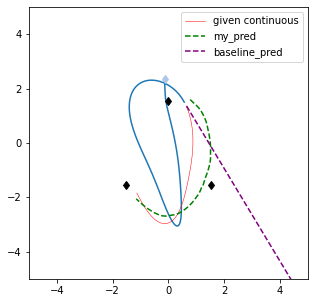

Simuation#6
Charges [-0.48912768 -0.53956225 -0.53497113]


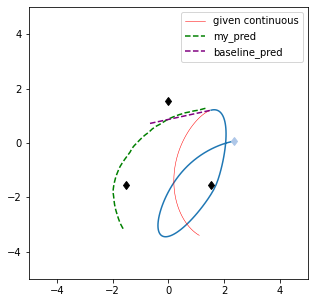

Simuation#7
Charges [-0.17141219 -0.38988138 -0.21918364]


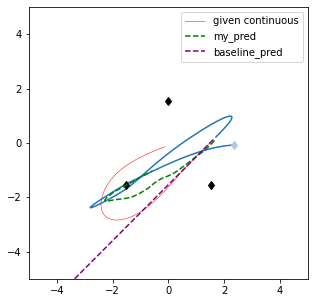

Simuation#8
Charges [-0.36186577 -0.85073117 -0.15300605]


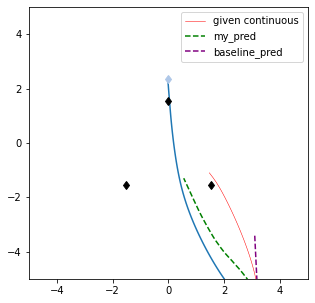

Simuation#9
Charges [-0.37120766 -0.09868825 -0.31392034]


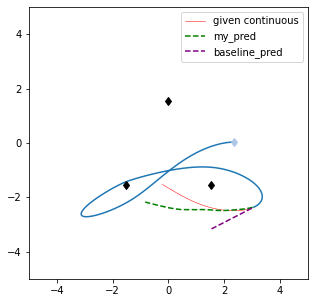

Simuation#10
Charges [-0.80701162 -0.35913297 -0.66586403]


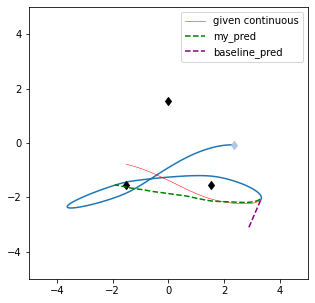

Simuation#11
Charges [-0.39431929 -0.64303829 -0.60342279]


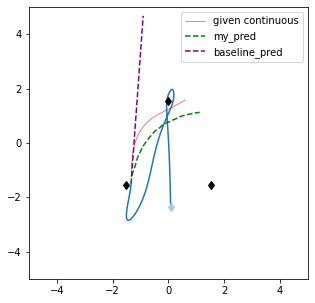

Simuation#12
Charges [-0.4106839  -0.08464682 -0.99831876]


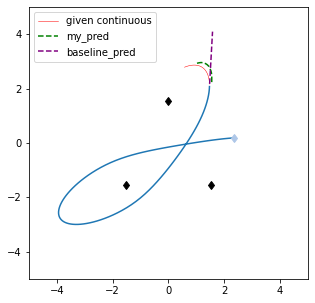

Simuation#13
Charges [-0.9355202  -0.96350592 -0.81551009]


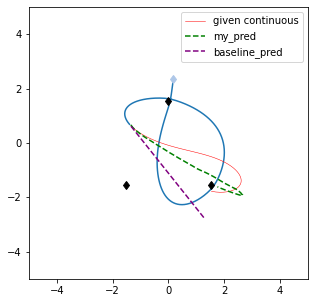

Simuation#14
Charges [-0.72250353 -0.03036705 -0.82097582]


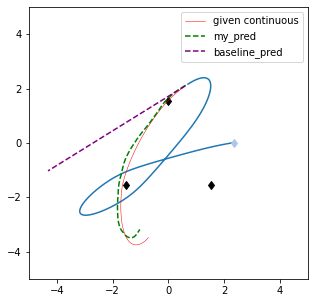

Simuation#15
Charges [-0.20083667 -0.51991506 -0.88864394]


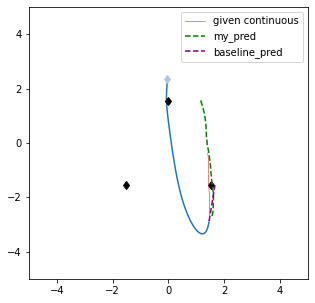

Simuation#16
Charges [-0.1399828  -0.60077349 -0.94377978]


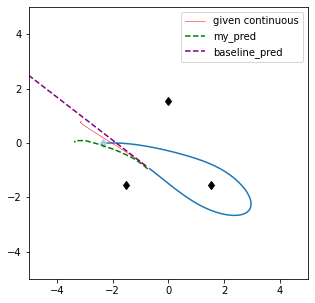

Simuation#17
Charges [-0.87793336 -0.96306084 -0.77616084]


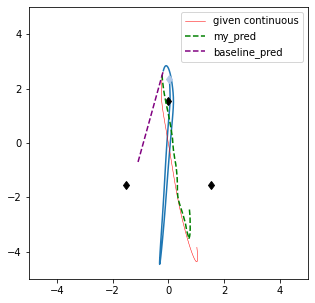

Simuation#18
Charges [-0.12823529 -0.70660002 -0.3275637 ]


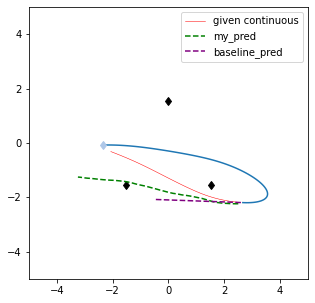

Simuation#19
Charges [-0.00693732 -0.02280698 -0.45170953]


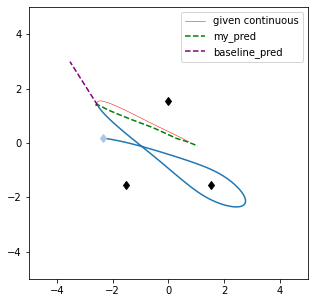

Simuation#20
Charges [-0.19566214 -0.50865248 -0.61905666]


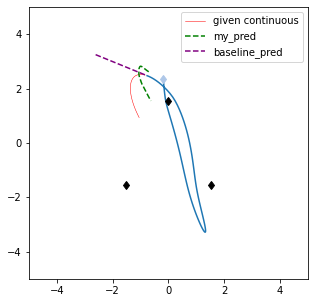

Simuation#21
Charges [-0.01904122 -0.20077435 -0.36067369]


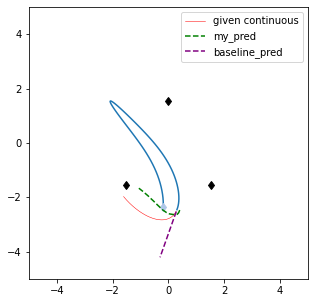

Simuation#22
Charges [-0.4499931  -0.15693644 -0.72039347]


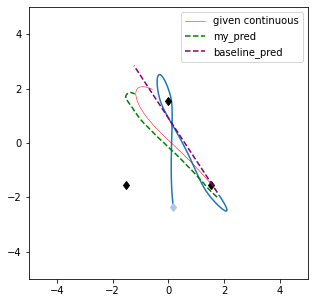

Simuation#23
Charges [-0.03151109 -0.02315498 -0.99348561]


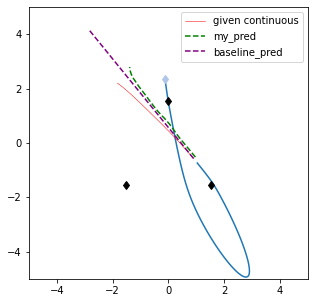

Simuation#24
Charges [-0.27367139 -0.9003474  -0.82114085]


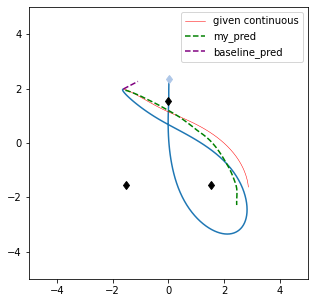

Simuation#25
Charges [-0.33200307 -0.03253087 -0.84798126]


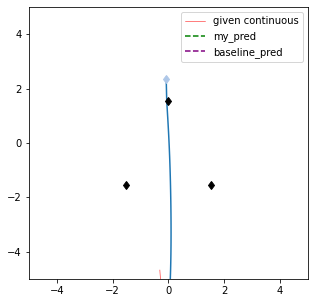

Simuation#26
Charges [-0.75079983 -0.27656042 -0.16604467]


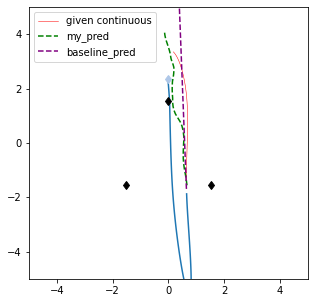

Simuation#27
Charges [-0.09808531 -0.5563076  -0.58221579]


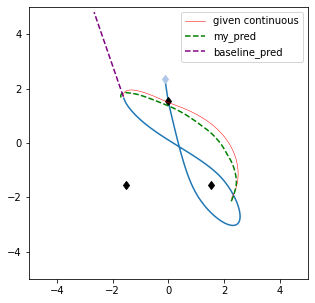

Simuation#28
Charges [-0.65385043 -0.36736913 -0.72350087]


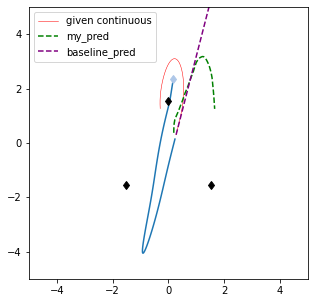

Simuation#29
Charges [-0.70948082 -0.67689955 -0.78044154]


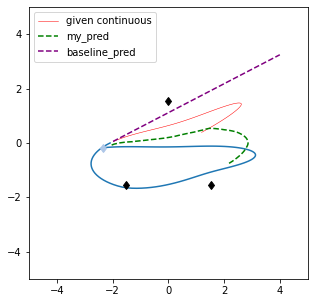

Simuation#30
Charges [-0.76540498 -0.0763432  -0.28205971]


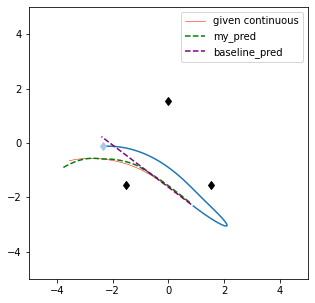

Simuation#31
Charges [-0.05522717 -0.26184388 -0.88388827]


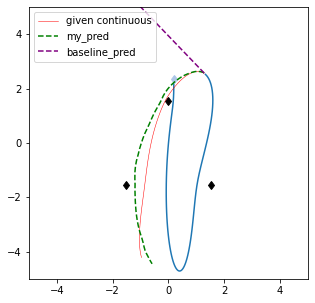

Simuation#32
Charges [-0.90294538 -0.81187233 -0.86284005]


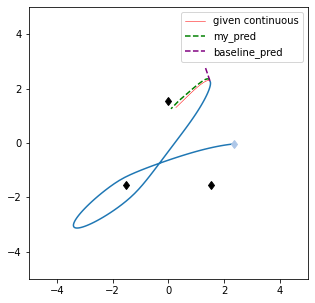

Simuation#33
Charges [-0.35175656 -0.47319647 -0.11388248]


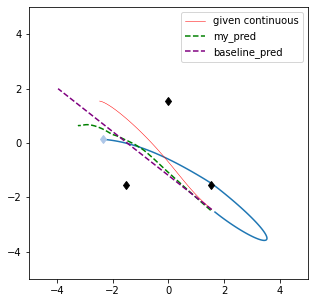

Simuation#34
Charges [-0.16157069 -0.9385916  -0.53660326]


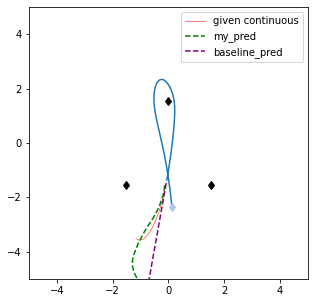

Simuation#35
Charges [-0.93174714 -0.00651585 -0.99947865]


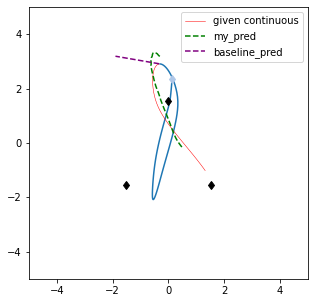

Simuation#36
Charges [-0.41459512 -0.36847363 -0.25877106]


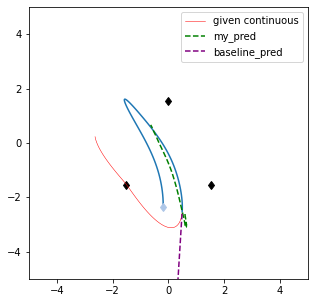

Simuation#37
Charges [-0.42841933 -0.00774541 -0.47831631]


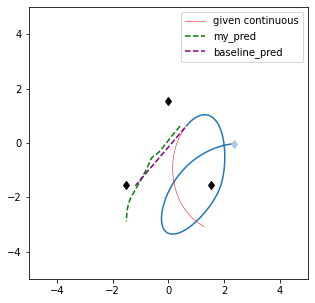

Simuation#38
Charges [-0.89750872 -0.08494919 -0.41676935]


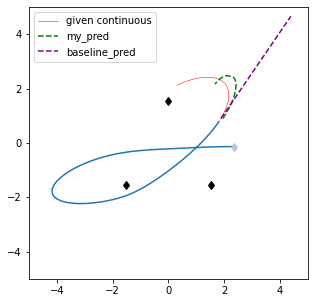

Simuation#39
Charges [-0.59331793 -0.25285633 -0.99039151]


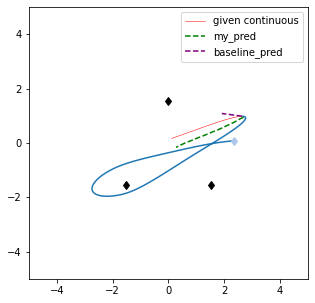

Simuation#40
Charges [-0.30924574 -0.72381331 -0.18780389]


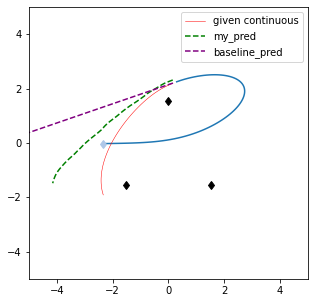

Simuation#41
Charges [-0.49245805 -0.16932145 -0.84001937]


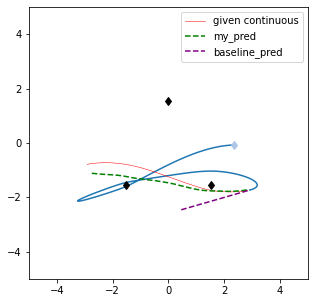

Simuation#42
Charges [-0.50900115 -0.46072513 -0.61144578]


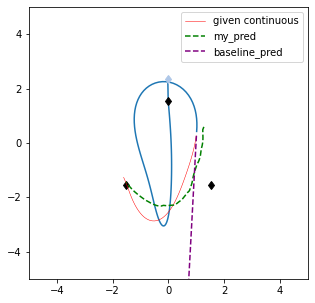

Simuation#43
Charges [-0.79920629 -0.96243395 -0.58256851]


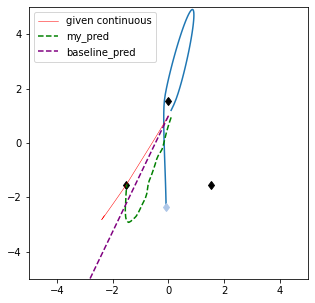

Simuation#44
Charges [-0.69515886 -0.35658944 -0.49563584]


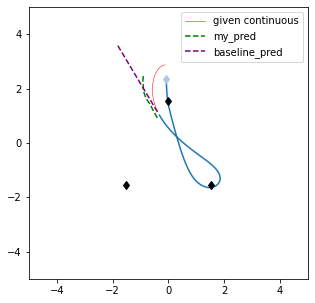

Simuation#45
Charges [-0.89831601 -0.42149588 -0.67428514]


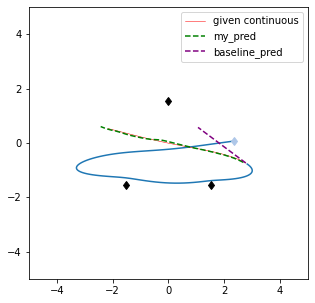

Simuation#46
Charges [-0.16830727 -0.87608954 -0.80660863]


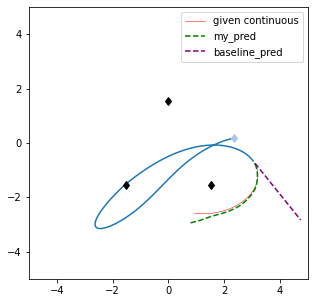

Simuation#47
Charges [-0.35424691 -0.55251781 -0.59553632]


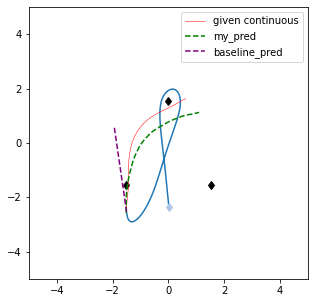

Simuation#48
Charges [-0.47461905 -0.15552425 -0.096797  ]


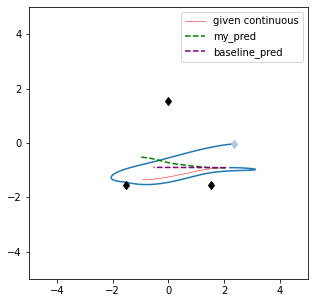

Simuation#49
Charges [-0.18803736 -0.16267659 -0.46971314]


In [ ]:
for i in range(50):
  predicted_continus=recursive_predict(torch.tensor(simulation_test[i],dtype=torch.float),charges_test[i], window_size, i)
  base_pred = base_predict(torch.tensor(simulation_test[i],dtype=torch.float),charges_test[i], window_size, i)
  plot_example(simulation_test[i], simulation_continued_test[i], np.array(predicted_continus), np.array(base_pred))
  print(f'Simuation#{i}')
  print(f'Charges {charges_train[i]}')